# Subsampling examples

In [1]:
import multiprocessing as mp
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sys
import warnings
import os
from random import randint

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
os.getcwd()

'/Users/brunobarbarioli/Documents/Research/OTSS'

In [13]:
from algorithms.online_subsampler import *
from algorithms.analytics import *
from algorithms.breakpoint_detection import *
from algorithms.empirical_bernstein import *
import algorithms.uniform_subsampler

## Synthetic data

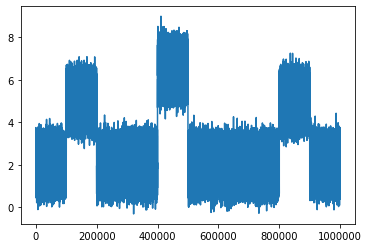

In [10]:
#Piecewise Stationary series

#Parameters
n = 1000000
mu = 2
sigma = 0.5

#Gaussian distribution
x = np.random.normal(mu, sigma, n)

#Altered means
x[100000:200000] += 3
x[400000:500000] += 4.5
x[600000:700000] += 0
x[800000:900000] += 3

#plot
plt.plot(x)

In [11]:
# Real average for comparison

real_average = np.random.normal(mu, 0, n)
real_average[100000:200000] += 3
real_average[400000:500000] += 4.5
real_average[600000:700000] += 0
real_average[800000:900000] += 3

In [12]:
# Using empirical Bernstein subsampler

subsample_eb = empirical_bernstein(0.05,0.01,2.5,x)

#calculating the mean
subsample_eb_mean = np.full(1000000,np.mean(subsample_eb))

breakpoint started
subsampler started
Interval size:  17747
Relative sample size:  5.07 %
----*----
Interval size:  35532
Relative sample size:  2.48 %
----*----
Interval size:  46721
Relative sample size:  1.9 %
----*----
Interval size:  17731
Relative sample size:  1.64 %
----*----
Interval size:  72961
Relative sample size:  0.38 %
----*----
Interval size:  9308
Relative sample size:  3.22 %
----*----
Interval size:  20426
Relative sample size:  4.31 %
----*----
Interval size:  37125
Relative sample size:  2.4 %
----*----
Interval size:  71371
Relative sample size:  1.25 %
----*----
Interval size:  31616
Relative sample size:  2.78 %
----*----
Interval size:  4320
Relative sample size:  20.14 %
----*----
Interval size:  35142
Relative sample size:  2.7 %
----*----
Interval size:  1106
Relative sample size:  20.8 %
----*----
Interval size:  10131
Relative sample size:  2.17 %
----*----
Interval size:  24344
Relative sample size:  0.94 %
----*----
Interval size:  64419
Relative sample

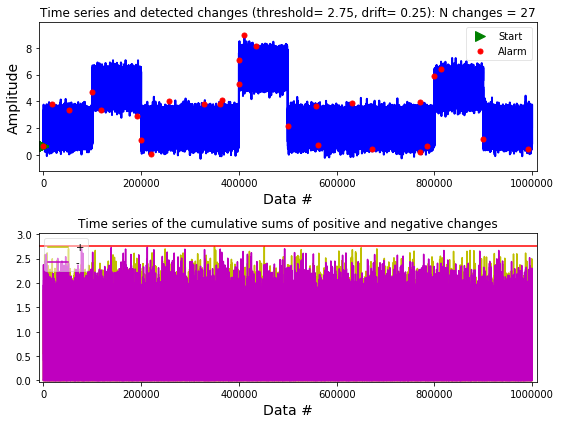

Process Process-5:
Traceback (most recent call last):
  File "/Users/brunobarbarioli/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/brunobarbarioli/opt/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/brunobarbarioli/Documents/Research/OTSS/algorithms/online_subsampler.py", line 95, in online_subsampler
    indexes = queue.get()
  File "/Users/brunobarbarioli/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/Users/brunobarbarioli/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Users/brunobarbarioli/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/Users/brunobarbarioli/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 379

In [19]:
# Online subsampler

queue = mp.Queue()
return_queue = mp.Queue()
index_queue = mp.Queue()
p1 = mp.Process(target = detection, args = (x, queue, 2.75, .25, False, True))
p2 = mp.Process(target = online_subsampler, args = (0.05,0.01,2.5,10,x, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

In [ ]:
# Calculating statistics
sub, rel_size = subsample_analysis(return_queue, index_queue)

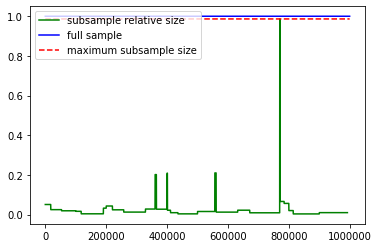

In [21]:
# Plotting subsample size
plt.plot(rel_size, color = 'green')
plt.plot(np.full(1000000,1), color = 'blue')
plt.plot(np.full(1000000,max(rel_size)), color='red', linestyle ='--' )
plt.legend(['subsample relative size', 'full sample', 'maximum subsample size'], loc='upper left')

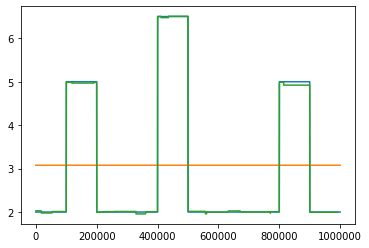

In [18]:
#plotting mean

plt.plot(real_average)
plt.plot(subsample_eb_mean)
plt.plot(sub)

## Real Data

### Example 1 - UCI Household power consumption
https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption

In [22]:
path = '/Users/brunobarbarioli/Documents/Research/OTSS/datasets/household_power_consumption.txt'
data = pd.read_csv(path, sep = ';')

#### Exploratory data analysis and data cleaning


In [23]:
print(data.head(5))

         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000            17.0  
4           15.800          0.000          1.000            17.0  


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [25]:
data = data[data.Sub_metering_1 != '?']
data = data[data.Sub_metering_2 != '?']
data = data[data.Sub_metering_3 != '?']

In [26]:
data.index = pd.to_datetime(data['Date'] +' '+ data['Time'])
data_clean = data.drop(columns = ['Date', 'Time'])

In [27]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 125.1+ MB


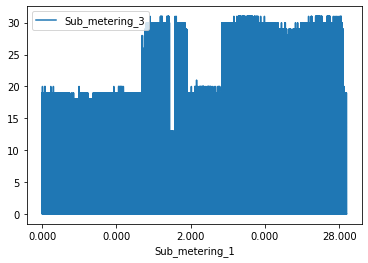

In [30]:
data_clean.plot('Sub_metering_3')

In [34]:
x = data_clean['Sub_metering_3']

#### Model

In [35]:
#breakpoint detection Threshold = 5, drift = 17.5

queue = mp.Queue()
p1 = mp.Process(target = detection, args = (x, queue, 5, 17.5, False, False))
p2 = mp.Process(target = online_subsampler, args = (0.05,0.01,10,5,x, queue, return_queue,index_queue, 1000))

p1.start()
p2.start()

breakpoint started
subsampler started
Interval size:  779524
Relative sample size:  0.09 %
----*----
Interval size:  32769
Relative sample size:  7.1 %
----*----
Interval size:  128110
Relative sample size:  1.55 %
----*----
Interval size:  332783
Relative sample size:  0.42 %
----*----
Interval size:  32057
Relative sample size:  5.65 %
----*----
Interval size:  12410
Relative sample size:  30.66 %
----*----
Interval size:  12666
Relative sample size:  17.21 %
----*----
Interval size:  55506
Relative sample size:  100%
----*----
Interval size:  36512
Relative sample size:  100%
----*----
Interval size:  2284
Relative sample size:  60.42 %
----*----
Interval size:  13975
Relative sample size:  29.12 %
----*----
Interval size:  5511
Relative sample size:  79.57 %
----*----
Interval size:  49414
Relative sample size:  0.53 %
----*----
Interval size:  18473
Relative sample size:  17.59 %
----*----
Interval size:  41776
Relative sample size:  0.44 %
----*----
Interval size:  2007
Relative 

In [36]:
sub, rel_size = subsample_analysis(return_queue, index_queue)

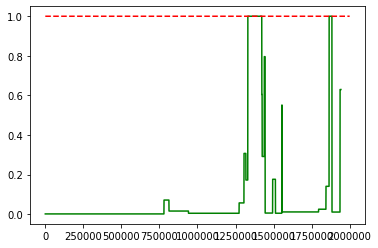

In [40]:
# Plotting subsample size
plt.plot(rel_size, color = 'green')
#plt.plot(np.full(2000000,1), color = 'blue')
plt.plot(np.full(2000000,max(rel_size)), color='red', linestyle ='--' )
#plt.legend(['subsample relative size', 'full sample', 'maximum subsample size'], loc='upper left')

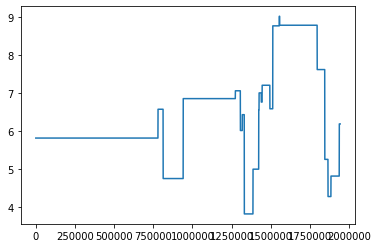

In [41]:
#plotting mean

#plt.plot(real_average)
#plt.plot(subsample_eb_mean)
plt.plot(sub)